Placenta height: 3.181642481356553
Sphere radius: 14.518876558339993
placentone_removal_sphere_radius: 30.461511238292196
placentone_removal_height: 1.8
cotyledon_wall_heights: [1.06535941,1.76038427,1.63020321,1.87078275,0.74165982,1.60105765]
lobule_wall_heights: [0.5326797 ,0.88019214,0.8151016 ,0.93539138,0.37082991,0.80052882]
Voronoi generating points : 
 [[ 6.6801457   1.1839978 ]
 [ 2.248453   -4.7815226 ]
 [-0.41532437  0.81617302]
 [ 1.2449482   6.0864235 ]
 [-5.4186901   3.7657733 ]
 [-4.6876481  -4.1060797 ]]


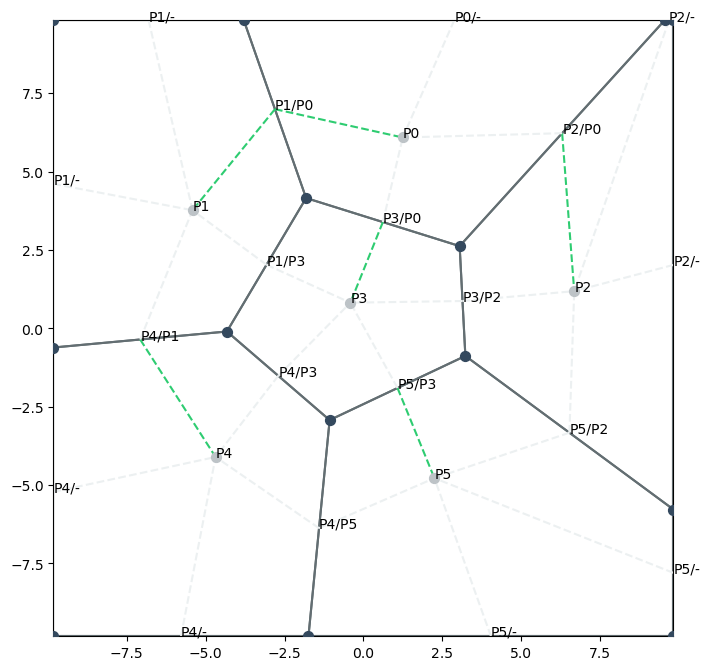

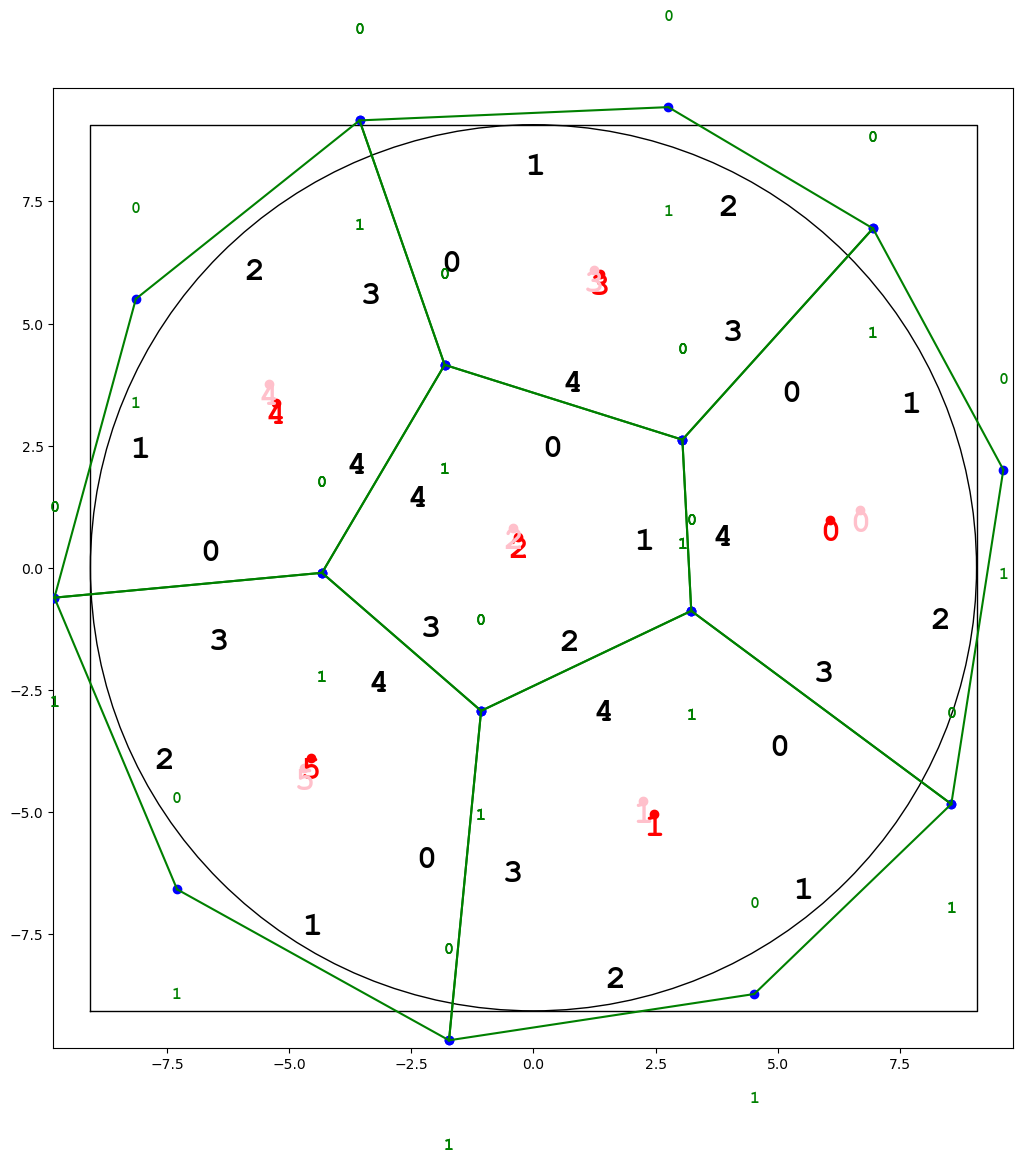

Adding septal wall vein to placentone  0
IN SEPTAL_VEIN_HEIGHT
btm_hgt: 0.5970844965345474
top_hgt: 2.021503222239349
rel_hgt: 1.834418725704802
hgt: 0.7410913307122156
ratio: 0.1010986668308601
wall_vein_buffer_on_wall: 0.20500000000000002
OUT SEPTAL_VEIN_HEIGHT
WARNING - total no. of curves found with centre [3.23997304 0.85679476 0.74109133] is 2
Curves found are [10, 49]
Found curve: 10
Added septal wall
face no: 46
pt in wall: [3.142104453516624,0.8517213135716444,0.7410913307122156]
norm out cell: [-0.9986590413477766,-0.05176986704966208,0.0]
Adding septal wall vein to placentone  1
IN SEPTAL_VEIN_HEIGHT
btm_hgt: 1.0992889417392249
top_hgt: 1.843329318124331
rel_hgt: 1.1540403763851064
hgt: 1.8074262869428517
ratio: 0.9517458563795786
wall_vein_buffer_on_wall: 0.20500000000000002
OUT SEPTAL_VEIN_HEIGHT
WARNING - total no. of curves found with centre [-1.16164744 -4.8804676   1.80742629] is 2
Curves found are [118, 130]
Found curve: 118
Added septal wall
face no: 48
pt in wall: [

SystemExit: -2

In [19]:
import os
import sys
import importlib

import math
import scipy
import numpy
import copy
import time

import gmsh
import matplotlib
import foronoi

import placenta_const
import placenta_plots as plots
import placenta_fns as fns
import placenta_classes as clses
import placenta_foronoi as frni
import placenta_shape as shape
import placenta_vessels as vessels
import placenta_regions as regions
import placenta_fields as fields

importlib.reload(placenta_const)
importlib.reload(plots)
importlib.reload(fns)
importlib.reload(clses)
importlib.reload(frni)
importlib.reload(shape)
importlib.reload(vessels)
importlib.reload(regions)
importlib.reload(fields)

from placenta_const import *

# Initialise GMSH
gmsh.initialize()
gmsh = set_gmsh_optns(gmsh)
model = gmsh.model

########################### INITIALISE QUANTITIES ##########################
# Set up a bounding box object and storage
bounding_box = clses.BoundingBox()
#bounding_boxes = []

# Set up a face object and list storage
face = clses.Face()
#inlet_faces = []
outlet_faces = []
surf_COMs_to_ignore = []
field_list = []
no_inlets = 0
no_outlets = 0 # First basal, then peripheral, then septal wall
no_lobule_veins = 0
####################### END OF INITIALISE QUANTITIES #######################

###################### REMOVAL OBJECTS #######################
# Debug box, whole domain
#Box(1000) = {-BasalPlateSphereRadius*2,-BasalPlateSphereRadius*2,-BasalPlateSphereRadius*2,
#                BasalPlateSphereRadius*4,BasalPlateSphereRadius*4,BasalPlateSphereRadius*4}

# Box that cuts off initial sphere past placenta_height
model.occ.addBox(-initial_sphere_radius,-initial_sphere_radius,initial_sphere_radius*2, \
                initial_sphere_radius*2,initial_sphere_radius*2,-initial_sphere_radius*2+placenta_height, \
                1000)
# Cylinder for straight top part
#model.occ.addCylinder(0.0,0.0,placenta_height, \
#                        0.0,0.0,top_cyl_height, \
#                        placenta_radius,1001)

###################### END OF REMOVAL OBJECTS #######################

print(f"Placenta height: {placenta_height}")
print(f"Sphere radius: {initial_sphere_radius}")
print(f"placentone_removal_sphere_radius: {removal_sphere_radius(placentone_removal_height)}")
print(f"placentone_removal_height: {placentone_removal_height}")
print(f"cotyledon_wall_heights: {numpy.array2string(cotyledon_wall_heights, separator=',')}")
print(f"lobule_wall_heights: {numpy.array2string(lobule_wall_heights, separator=',')}")

#Sphere(1) = {0.0,0.0,initial_sphere_radius,initial_sphere_radius}
model.occ.addSphere(*initial_sphere_centre,initial_sphere_radius,1)

# model.occ.cut([(3,1)], [(3,1000)], tag=2, removeObject=True, removeTool=True)  - omitting tag=.. means that the smallest tag no. that is deleted is taken
# Putting tag=lowest_tag_no gives error
model.occ.cut([(3,1)], [(3,1000)])
#model.occ.fuse([(3,1)], [(3,1001)])


'''
# Debug
field_no = 100
model.mesh.field.add("Constant",field_no)
model.mesh.field.setNumber(field_no,"IncludeBoundary",1)
model.mesh.field.setNumber(field_no,"VIn",DomSize/2.0)
model.mesh.field.setNumber(field_no,"VOut",DomSize/2.0)
model.mesh.field.setNumbers(field_no,"VolumesList",[1,2,3,4,5,6,7,8,9,10])
field_list = field_list + [field_no]
model.mesh.field.setAsBackgroundMesh(100)
'''


points = shape.setup_voronoi_pts()
v = shape.setup_voronoi_diagram(points)

model.occ.synchronize()

[cotyledon_node_set,cotyledon_edge_set,cotyledons] = \
    shape.create_cotyledons(model,points,no_placentones,v)

#cotyledon_node_set.print_members()

model.occ.synchronize()

[lobule_node_set,lobule_edge_set,no_lobules,lobules] = \
        shape.create_lobules(model,no_placentones,cotyledons, \
        cotyledon_node_set,cotyledon_edge_set)
        
model.occ.synchronize()

[no_inlets,no_cavities,bounding_boxes,inlet_faces,cavities,no_lobule_veins,no_outlets,outlet_faces] = \
        vessels.add_spiral_arteries_and_lobule_veins(model,no_lobules, \
            cotyledons,lobules,no_inlets,no_lobule_veins,no_outlets,outlet_faces)

model.occ.synchronize()
 
[model,no_marginal_sinus_veins_added,no_outlets,outlet_faces] = \
    vessels.create_marginal_veins(model,cotyledons,lobules,no_outlets,outlet_faces)

model.occ.synchronize()

[no_septal_wall_veins,no_outlets,outlet_faces] = \
    vessels.create_septal_veins(model,no_placentones,cotyledons, \
        cotyledon_edge_set,no_outlets,outlet_faces)


##################################################################
###################### SEPTAL WALL VEINS #########################
##################################################################

model.occ.synchronize()
gmsh.fltk.run()





  
start = time.time()
regions.create_ellipsoid_cavities(model,cavities)
end = time.time()
print(f"Time to compute ellipsoid cavities: {end-start}")

print(f"Creating septal fragments")

'''
model.occ.synchronize()
gmsh.fltk.run()
gmsh.finalize()
sys.exit(-2)
'''

start = time.time()
[model,surf_COMs_to_ignore] = regions.create_septal_fragment(model,outlet_faces,surf_COMs_to_ignore)
end = time.time()
print(f"Time to compute septal fragments: {end-start}")

print(f"Finished septal fragments")

model.occ.synchronize()

print(f"Adding nodes to inlet surfaces")
    
surface_label_pairs = model.occ.getEntities(dim=2)

no_surfs = len(surface_label_pairs)
surface_centres = numpy.zeros((3,no_surfs))

for pair_no in range(0,no_surfs):
    surf_pair = surface_label_pairs[pair_no]
    surf_no = surf_pair[1]
    surface_centres[:,pair_no] = model.occ.getCenterOfMass(2,surf_no)
    
for inlet_face_no in range(0,no_inlets):
    for pair_no in range(0,no_surfs):
        sq_dist = numpy.linalg.norm( \
                        inlet_faces[inlet_face_no].centre[:]-surface_centres[:,pair_no] \
                                   )
        if (sq_dist < tol):
            surf_pair = surface_label_pairs[pair_no]
            surf_no = surf_pair[1]
            inlet_faces[inlet_face_no].face_no = surf_no
            
            ##################### ADD NODES TO INLET CENTRES #####################   
            embed_pt_no = model.occ.addPoint(*inlet_faces[inlet_face_no].centre,1.0)
            model.occ.synchronize()
            model.mesh.embed(0, [embed_pt_no], 2, surf_no)
            model.occ.synchronize()
            ##################### ADD NODES TO INLET CENTRES #####################   
            
            print("inlet_face_no ",inlet_face_no," corresponds to surface ",surf_no)
            break
        
        
for outlet_face_no in range(0,no_outlets):
    for pair_no in range(0,no_surfs):
        sq_dist = numpy.linalg.norm( \
                        outlet_faces[outlet_face_no].centre[:]-surface_centres[:,pair_no] \
                                   )
        if (sq_dist < tol):
            surf_pair = surface_label_pairs[pair_no]
            surf_no = surf_pair[1]
            outlet_faces[outlet_face_no].face_no = surf_no
            
            ##################### ADD NODES TO OULET CENTRES #####################   
            embed_pt_no = model.occ.addPoint(*outlet_faces[outlet_face_no].centre,1.0)
            model.occ.synchronize()
            model.mesh.embed(0, [embed_pt_no], 2, surf_no)
            model.occ.synchronize()
            ##################### ADD NODES TO OUITLET CENTRES #####################   
            
            print("outlet_face_no ",outlet_face_no," corresponds to surface ",surf_no)
            break    
     




    
######################## PHYSICAL GROUP SETUP ########################

# Need a sync before adding physical groups, otherwise they aren't properly set up
# and lower-dimensional, non-physical-grouped entities are saved
model.occ.synchronize()

# Set up quantities
no_inlets_outlets = no_inlets+no_outlets
print("no_inlets_outlets: ",no_inlets_outlets)

surface_label_pairs = model.occ.getEntities(dim=2)
surface_label_pairs_no_slip = copy.deepcopy(surface_label_pairs)

no_surfs = len(surface_label_pairs)
surface_centres = numpy.zeros((3,no_surfs))
for pair_no in range(0,no_surfs):
    surf_pair = surface_label_pairs[pair_no]
    surf_no = surf_pair[1]
    surface_centres[:,pair_no] = model.occ.getCenterOfMass(2,surf_no)

for outlet_face_no in range(0,no_outlets):
    for pair_no in range(0,no_surfs):
        sq_dist = numpy.linalg.norm( \
                        outlet_faces[outlet_face_no].centre[:]-surface_centres[:,pair_no] \
                                   )
        if (sq_dist < tol):
            surf_pair = surface_label_pairs[pair_no]
            surf_no = surf_pair[1]
            outlet_faces[outlet_face_no].face_no = surf_no
            
            apto_bdry_no = 101+outlet_face_no
            outlet_faces[outlet_face_no].update_apto_bdry_no(apto_bdry_no)
            model.addPhysicalGroup(2, [surf_no], apto_bdry_no, "Outlet "+str(outlet_face_no))
            
            surface_label_pairs_no_slip[pair_no] = (-1,-1)
            print("outlet_face_no ",outlet_face_no," corresponds to surface ",surf_no)
            break
            
for inlet_face_no in range(0,no_inlets):
    for pair_no in range(0,no_surfs):
        sq_dist = numpy.linalg.norm( \
                        inlet_faces[inlet_face_no].centre[:]-surface_centres[:,pair_no] \
                                   )
        if (sq_dist < tol):
            surf_pair = surface_label_pairs[pair_no]
            surf_no = surf_pair[1]
            inlet_faces[inlet_face_no].face_no = surf_no 
            
            apto_bdry_no = 2+inlet_face_no
            inlet_faces[inlet_face_no].update_apto_bdry_no(apto_bdry_no)
            model.addPhysicalGroup(2, [surf_no], apto_bdry_no, "Inlet "+str(inlet_face_no))
            
            surface_label_pairs_no_slip[pair_no] = (-1,-1)
            print("inlet_face_no ",inlet_face_no," corresponds to surface ",surf_no)
            break


for cavity_no in range(0, no_cavities):
    for pair_no in range(0,no_surfs):
        sq_dist = numpy.linalg.norm( \
                        cavities[cavity_no].COM[:]-surface_centres[:,pair_no] \
                                   )
        
        if (sq_dist < large_geom_tol):               
            surf_pair = surface_label_pairs[pair_no]
            surf_no = surf_pair[1]   
            
            surface_label_pairs_no_slip[pair_no] = (-1,-1)
            print("cavity ghost surface ",cavity_no," corresponds to surface ",surf_no)
            
for surf_COM in surf_COMs_to_ignore:
    for pair_no in range(0,no_surfs):
        sq_dist = numpy.linalg.norm( \
                        surf_COM[:]-surface_centres[:,pair_no] \
                                   )
        
        if (sq_dist < large_geom_tol):               
            surf_pair = surface_label_pairs[pair_no]
            surf_no = surf_pair[1]   
            
            surface_label_pairs_no_slip[pair_no] = (-1,-1)
            print("outlet plane ghost surface ",surf_COM," corresponds to surface ",surf_no)

        
surface_label_pairs_no_slip[:] = [value for value in surface_label_pairs_no_slip if value != (-1,-1)]
no_no_slip_surfs = len(surface_label_pairs_no_slip)
surface_nos_no_slip = [value[1] for value in surface_label_pairs_no_slip]




model.addPhysicalGroup(2, surface_nos_no_slip, 1, "No slip")





model.addPhysicalGroup(3, [pair[1] for pair in model.occ.getEntities(3)], 1, "Domain")


# Set the baseline, coarse mesh size
field_list = []

field_no = 100
model.mesh.field.add("Constant",field_no)
model.mesh.field.setNumber(field_no,"IncludeBoundary",1)
model.mesh.field.setNumber(field_no,"VIn",DomSize)
model.mesh.field.setNumber(field_no,"VOut",DomSize)
model.mesh.field.setNumbers(field_no,"VolumesList",[1])
field_list = field_list + [field_no]

for inlet_no in range(0,no_inlets):
    field_no = 201+inlet_no
    start_pt = numpy.copy(inlet_faces[inlet_no].centre)
    normal = numpy.copy(inlet_faces[inlet_no].outward_unit_normal)
    start_pt = start_pt + mesh_offset_length*normal
    
    x_diff = -1.25*septal_vessel_length*normal[0]
    y_diff = -1.25*septal_vessel_length*normal[1]
    z_diff = -1.25*septal_vessel_length*normal[2]
    
    model.mesh.field.add("Cylinder",field_no)
    model.mesh.field.setNumber(field_no,"VIn",IOSize)
    model.mesh.field.setNumber(field_no,"VOut",DomSize)
    model.mesh.field.setNumber(field_no,"Radius",septal_artery_radius*1.75)
    model.mesh.field.setNumber(field_no,"XCenter",start_pt[0])
    model.mesh.field.setNumber(field_no,"YCenter",start_pt[1])
    model.mesh.field.setNumber(field_no,"ZCenter",start_pt[2])
    model.mesh.field.setNumber(field_no,"XAxis",x_diff)
    model.mesh.field.setNumber(field_no,"YAxis",y_diff)
    model.mesh.field.setNumber(field_no,"ZAxis",z_diff)
    
    field_list = field_list + [field_no]
    
# Lobuile veins eins
for outlet_no in range(0,no_lobule_veins):

    field_no = 301+outlet_no
    start_pt = numpy.copy(outlet_faces[outlet_no].centre)
    normal = numpy.copy(outlet_faces[outlet_no].outward_unit_normal)
    length = outlet_faces[outlet_no].cylinder_length

    end_pt = start_pt - length*normal
    field_radius = outlet_faces[outlet_no].cylinder_radius+outlet_faces[outlet_no].cylinder_fillet+mesh_offset_length
    
    model.mesh.field.add("Ball",field_no)
    model.mesh.field.setNumber(field_no,"VIn",BasalSize)
    model.mesh.field.setNumber(field_no,"VOut",DomSize)
    model.mesh.field.setNumber(field_no,"Radius",1.5*field_radius)
    model.mesh.field.setNumber(field_no,"Thickness",field_radius/2.0)
    model.mesh.field.setNumber(field_no,"XCenter",end_pt[0])
    model.mesh.field.setNumber(field_no,"YCenter",end_pt[1])
    model.mesh.field.setNumber(field_no,"ZCenter",end_pt[2])
        
    field_list = field_list + [field_no]
    
    x_diff = -1.1*length*normal[0]
    y_diff = -1.1*length*normal[1]
    z_diff = -1.1*length*normal[2]
    
    # Add vein pipe mesh size
    field_no = 1301+outlet_no
    
    total_radius = outlet_faces[outlet_no].cylinder_radius+outlet_faces[outlet_no].cylinder_fillet
    
    model.mesh.field.add("Cylinder",field_no)
    model.mesh.field.setNumber(field_no,"VIn",BasalSize)
    model.mesh.field.setNumber(field_no,"VOut",DomSize)
    model.mesh.field.setNumber(field_no,"Radius",total_radius*1.1)
    model.mesh.field.setNumber(field_no,"XCenter",start_pt[0])
    model.mesh.field.setNumber(field_no,"YCenter",start_pt[1])
    model.mesh.field.setNumber(field_no,"ZCenter",start_pt[2])
    model.mesh.field.setNumber(field_no,"XAxis",x_diff)
    model.mesh.field.setNumber(field_no,"YAxis",y_diff)
    model.mesh.field.setNumber(field_no,"ZAxis",z_diff)
        
    field_list = field_list + [field_no]
    
# Marginal sinus veins
for outlet_no in range(no_lobule_veins,no_lobule_veins+no_marginal_sinus_veins_added):

    field_no = 301+outlet_no
    start_pt = numpy.copy(outlet_faces[outlet_no].centre)
    normal = numpy.copy(outlet_faces[outlet_no].outward_unit_normal)
    length = outlet_faces[outlet_no].cylinder_length

    end_pt = start_pt - length*normal
    field_radius = outlet_faces[outlet_no].cylinder_radius+outlet_faces[outlet_no].cylinder_fillet+mesh_offset_length
    
    model.mesh.field.add("Ball",field_no)
    model.mesh.field.setNumber(field_no,"VIn",MarginalSize)
    model.mesh.field.setNumber(field_no,"VOut",DomSize)
    model.mesh.field.setNumber(field_no,"Radius",1.5*field_radius)
    model.mesh.field.setNumber(field_no,"Thickness",field_radius/2.0)
    model.mesh.field.setNumber(field_no,"XCenter",end_pt[0])
    model.mesh.field.setNumber(field_no,"YCenter",end_pt[1])
    model.mesh.field.setNumber(field_no,"ZCenter",end_pt[2])
        
    field_list = field_list + [field_no]
    
    x_diff = -1.1*length*normal[0]
    y_diff = -1.1*length*normal[1]
    z_diff = -1.1*length*normal[2]
    
    # Add vein pipe mesh size
    field_no = 1301+outlet_no
    
    total_radius = outlet_faces[outlet_no].cylinder_radius+outlet_faces[outlet_no].cylinder_fillet
    
    model.mesh.field.add("Cylinder",field_no)
    model.mesh.field.setNumber(field_no,"VIn",MarginalSize)
    model.mesh.field.setNumber(field_no,"VOut",DomSize)
    model.mesh.field.setNumber(field_no,"Radius",total_radius*1.1)
    model.mesh.field.setNumber(field_no,"XCenter",start_pt[0])
    model.mesh.field.setNumber(field_no,"YCenter",start_pt[1])
    model.mesh.field.setNumber(field_no,"ZCenter",start_pt[2])
    model.mesh.field.setNumber(field_no,"XAxis",x_diff)
    model.mesh.field.setNumber(field_no,"YAxis",y_diff)
    model.mesh.field.setNumber(field_no,"ZAxis",z_diff)
        
    field_list = field_list + [field_no]
    
# Other veins (e.g. septal walls)
for outlet_no in range(no_lobule_veins+no_marginal_sinus_veins_added,no_outlets):
    
    field_no = 301+outlet_no
    start_pt = numpy.copy(outlet_faces[outlet_no].centre)
    normal = numpy.copy(outlet_faces[outlet_no].outward_unit_normal)

    end_pt = start_pt - 1.5*vein_length*normal
    field_radius = numpy.linalg.norm(end_pt-start_pt)+mesh_offset_length
    
    model.mesh.field.add("Ball",field_no)
    model.mesh.field.setNumber(field_no,"VIn",VeinSize)
    model.mesh.field.setNumber(field_no,"VOut",DomSize)
    model.mesh.field.setNumber(field_no,"Radius",field_radius)
    model.mesh.field.setNumber(field_no,"Thickness",2.0*placentone_wall_thickness)
    model.mesh.field.setNumber(field_no,"XCenter",end_pt[0])
    model.mesh.field.setNumber(field_no,"YCenter",end_pt[1])
    model.mesh.field.setNumber(field_no,"ZCenter",end_pt[2])
    
    
    field_list = field_list + [field_no]
    



[model,field_list] = fields.refine_inside_around_cavity(model,no_cavities,cavities,field_list)
    
[model,field_list] = fields.refine_apex_cavity(model,no_cavities,cavities,field_list)
    
# Calculate the min of all
model.mesh.field.add("Min",900)
model.mesh.field.setNumbers(900,"FieldsList",field_list)

# Set the min field as the mesh size function
model.mesh.field.setAsBackgroundMesh(900)





with open("geom_info.csv","w") as store_geom:
    store_geom.write(
        "placenta_radius,placenta_volume,"
        "initial_sphere_radius,initial_sphere_centre_x,initial_sphere_centre_y,initial_sphere_centre_z,"
        "septal_artery_radius,septal_vein_radius,marginal_sinus_vein_radius,"
        "no_basal_plate_veins,no_peripheral_veins,no_septal_wall_veins\n")
    store_geom.write(
        f"{placenta_radius},{placenta_volume},{initial_sphere_radius},"
        f"{initial_sphere_centre[0]},{initial_sphere_centre[1]},{initial_sphere_centre[2]},"
        f"{septal_artery_radius},{septal_vein_radius},{marginal_sinus_vein_radius},"
        f"{no_lobule_veins},{no_marginal_sinus_veins_added},{no_outlets-no_lobule_veins-no_marginal_sinus_veins_added}")
    store_geom.close()



with open("mesh_info.csv","w") as store_faces:
    store_faces.write("bdry_no,radius,centre_x,centre_y,centre_z,normal_x,normal_y,normal_z\n")
    for inlet_face_no in range(0,no_inlets):
        inlet_face = inlet_faces[inlet_face_no]
        face_centre = inlet_face.centre
        face_normal = inlet_face.outward_unit_normal
        store_faces.write("{bdry_no},{r},{c1},{c2},{c3},{n1},{n2},{n3}" \
                        .format(bdry_no=inlet_face.apto_bdry_no,r=septal_vein_radius, \
                                c1=face_centre[0],c2=face_centre[1],c3=face_centre[2], \
                                n1=face_normal[0],n2=face_normal[1],n3=face_normal[2]))
        if (inlet_face_no < no_inlets-1):
            store_faces.write("\n")
    store_faces.close()
    
with open("outlet_info.csv","w") as store_faces:
    store_faces.write("bdry_no,radius,outside_centre_x,outside_centre_y,outside_centre_z,normal_x,normal_y,normal_z,vein_length,fillet_radius\n")
    for outlet_face_no in range(0,no_outlets):
        outlet_face = outlet_faces[outlet_face_no]
        face_centre = outlet_face.centre
        face_normal = outlet_face.outward_unit_normal
        outlet_length = outlet_face.cylinder_length
        outlet_fillet = outlet_face.cylinder_fillet
        store_faces.write("{bdry_no},{r},{c1},{c2},{c3},{n1},{n2},{n3},{vl},{fr}" \
                        .format(bdry_no=outlet_face.apto_bdry_no,r=outlet_face.cylinder_radius, \
                                c1=face_centre[0],c2=face_centre[1],c3=face_centre[2], \
                                n1=face_normal[0],n2=face_normal[1],n3=face_normal[2], \
                                vl=outlet_length,fr=outlet_fillet))
        if (outlet_face_no < no_outlets-1):
            store_faces.write("\n")
    store_faces.close()


with open("cavity_info.csv","w") as store_cavities:
    store_cavities.write("cavity_no,minor_axis,major_axis,centre_x,centre_y,centre_z,orientation_normal_x,orientation_normal_y,orientation_normal_z\n")
    for cavity_no in range(0, no_cavities):
        centre = cavities[cavity_no].centre
        normal = cavities[cavity_no].orientation_normal
        minor_axis = cavities[cavity_no].minor_axis
        major_axis = cavities[cavity_no].major_axis
        store_cavities.write(f"{cavity_no+1},{minor_axis},{major_axis},{centre[0]},{centre[1]},{centre[2]},{normal[0]},{normal[1]},{normal[2]}")
        if (cavity_no < no_cavities-1):
            store_cavities.write("\n")
    store_cavities.close()

with open("wall_info.csv","w") as wall_info:
    wall_info.write("cotyledon_no,wall_height\n")
    for c_no in range(0, no_placentones):
        wall_info.write(f"{c_no},{cotyledon_wall_heights[c_no]}")
        if (c_no < no_placentones-1):
            wall_info.write("\n")
    wall_info.close()


print(f"{placenta_id}_s{no_septal_wall_veins}p{no_marginal_sinus_veins_added}b{no_lobule_veins}_")

model.occ.synchronize()

#model.mesh.generate(3)

#mesh_ele_struct = model.mesh.getElements(dim=3,tag=-1)
#mesh_eles = mesh_ele_struct[1]
#print("Number of elements: ",len(mesh_eles[0]))

# Launch the GUI to see the results:
if (open_gmsh):
    if '-nopopup' not in sys.argv:
        gmsh.fltk.run()
    
gmsh.finalize()

In [ ]:
import os
import sys
import logging
import importlib

import math
import scipy
import numpy
import copy

import gmsh
import matplotlib
import foronoi

import shapely
import pointpats

import placenta_classes as clses
import placenta_fns as fns
import placenta_foronoi as frni
import placenta_const

importlib.reload(clses)
importlib.reload(fns)
importlib.reload(frni)
importlib.reload(placenta_const)

from placenta_const import *

#polygon = foronoi.Polygon([
#        (-0.8,-0.8),(1.0,-1.0), \
#        (1.0,1.0),(-1.0,1.0)
#    ])
#points = [(0.25,0.5),(-0.25,-0.8)]
#v = foronoi.Voronoi(polygon)
#v.create_diagram(points=points)
#frni.visualise_voronoi(v)

points = numpy.array([(-0.3,-0.5),(-0.7,0.5),(0.9,0.8),(1.0,-1.0)])
#points = numpy.array([(-1.0,-1.0),(-1.0,0.4),(1.0,1.0),(1.0,-0.5)])
points = numpy.array([ (64.87228043,  57.47182542),
 (100.20687641,  88.77554587),
 (129.98483581,  32.03838456),
 ( 84.14008553,  20.73866848)])
#points = numpy.array([ (24.87228043,  100.47182542),
# (100.20687641,  88.77554587),
# (129.98483581,  32.03838456),
# ( 84.14008553,  20.73866848)])

no_sites = 4
#pgon = shapely.Polygon(points)
#rand_pts = pointpats.random.poisson(pgon,intensity=None,size=no_sites)
#rand_pts = pointpats.random.normal(pgon,center=(0.0,0.0),size=4)
centroid = fns.cal_centroid(4,points)
rand_pts = numpy.zeros([4,2])
for i in range(0,4):
    rand_pts[i,:] = centroid+numpy.random.rand()
'''
print(f"points: {points}")
print(f"rand_pts: {rand_pts}")
err = 10.0
for iter_no in range(0,10):
    print(f"iteration {iter_no}")
    
    prev_pts = numpy.copy(rand_pts)
    # Need to repoint pgon_foronoi each time, it seems to get updated with points after create_diagram
    pgon_foronoi = foronoi.Polygon(points)
    v = foronoi.Voronoi(pgon_foronoi)
    v.create_diagram(points=rand_pts)
    frni.visualise_voronoi(v)
    
    for site_no in range(0,no_sites):
        [no_vertices,no_edges,vertices,edges] = fns.convert_foronoi_site(v.sites[site_no])
        print(f"site_no = {site_no}, no_vertices = {no_vertices}, vertices = {vertices}, no_edges = {no_edges}, edges = {edges}")
        #centroid = fns.cal_centroid(no_vertices,vertices)
        centroid = fns.cal_centre_polygon(no_vertices,vertices)
        rand_pts[site_no,:] = centroid
        
    err = numpy.linalg.norm(rand_pts-prev_pts)
    print(f"Error = {err}")
    
frni.visualise_voronoi(v)
'''  


rng = numpy.random.default_rng()           
print(rng.normal(loc=0.0,scale=0.5, size=1))
print(rng.normal(loc=0.0,scale=0.5, size=1))

rts = numpy.roots([1.0,0.0,3.0*placenta_radius**2,-6.0*placenta_volume/math.pi])
print(rts)
print(rts[2])
print(numpy.real(rts[2]))


In [ ]:
# REMEMBER THAT FORONOI/POLYGON.PY _get_intersection_.. NEED TO BE CHANGED TO
'''
    def _get_intersection_point(self, orig, end):
        p = self.points + [self.points[0]]
        points = []

        point = None

        for i in range(0, len(p) - 1):
            intersection_point = Algebra.get_intersection(orig, end, p[i], p[i + 1])
            if intersection_point:
                points.append(intersection_point)

        if len(points) == 0:
            point = None
        elif len(points) == 1:  # this is the actual change
            point = points[0]
        else:
            max_distance = Algebra.distance(orig, end)

            # Find the intersection point that is furthest away from the start
            if points:
                distances = [Algebra.distance(orig, p) for p in points]
                distances = [i for i in distances if i <= max_distance]
                if distances:
                    point = points[np.argmax(distances)]

        return point
'''
# Otherwise can randomly get empty cell

# Ideas that haven't worked out / save for future



'''
# Set the no-slip boundary on the assumption that the inlet, outlet boudaries are at the end of model.occ.getEntities(dim=2)
# If this ends up not being the case, another approach is to store the inlet, outlet GMSH labels, loop through model.occ.getEntities(dim=2)
# for boundary labels which don't belong to inlet, outlet and set that to 0
surface_label_pairs = model.occ.getEntities(dim=2)
no_surface_label_pairs = len(surface_label_pairs)
no_noslip_surfaces = no_surface_label_pairs-no_inlets_outlets
noslip_labels = [pair[1] for pair in surface_label_pairs[0:no_noslip_surfaces]]
#model.addPhysicalGroup(2, noslip_labels, 1, "Noslip")
#print("no slip boundary labels: ",noslip_labels)

start_inlet_no = model.occ.getMaxTag(2)-no_inlets_outlets+1
print("start_inlet_no: ",start_inlet_no)
#for inlet_no in range(0,no_inlets):
#    model.addPhysicalGroup(2, [start_inlet_no+inlet_no], 2+inlet_no, "Inlet")
    #print("adding surface no ",start_inlet_no+inlet_no," as inlet with bdry_no ",2+inlet_no)

start_outlet_no = model.occ.getMaxTag(2)-no_outlets+1
print("start_outlet_no: ",start_outlet_no)
#for outlet_no in range(0,no_outlets):
#    model.addPhysicalGroup(2, [start_outlet_no+outlet_no], 101+outlet_no, "Outlet")
    #print("adding surface no ",start_outlet_no+outlet_no," as outlet with bdry_no ",2+outlet_no)
'''







'''
# IsInside doesn't work properly if there isn't a node on the surface, presume related to https://gitlab.onelab.info/gmsh/gmsh/-/issues/1246
surfs = model.occ.getEntities(dim=2)
no_surfs = len(surfs)
print(surfs)
for i in range(0,no_surfs):
    inside = False
    print("i = ",i)
    pair = surfs[i]
    inside = model.isInside(2,pair[1],TEST_vein_pt)
    if (inside):
        print("INSIDE: ",pair[1])
'''



""" TEST """
#model.occ.fuse([(3,1)],[(1,2)])

#def removeEmbedded(dimTags, dim=-1):
#def getEmbedded(dim, tag):
#def removeDuplicateNodes(dimTags=[])
#def removeDuplicateElements(dimTags=[])
#def remove(tag)
#def list():

#model.occ.removeAllDuplicates()    
#model.occ.healShapes()    
    
#model.occ.addPoint(0.0,0.0,100.0,DomSize,curr_pt)
#model.occ.remove([(0,curr_pt)], recursive=False)
#print(model.mesh.getEmbedded(3, 1))
#model.mesh.removeEmbedded([(80)], dim=-1)    
 
    
"""    
fig = matplotlib.pyplot.figure(figsize=(10,10))
axis = matplotlib.pyplot.axes()
axis.set_xlim(-placenta_radius,placenta_radius)
axis.set_ylim(-placenta_radius,placenta_radius)

matplotlib.pyplot.plot(frni_placentone.centroid[0],frni_placentone.centroid[1],'bo')
for vertex_no in range(0,frni_placentone.no_vertices):
    matplotlib.pyplot.plot(frni_placentone.vertices[0,vertex_no],frni_placentone.vertices[1,vertex_no],'go')
    matplotlib.pyplot.plot(frni_placentone_shrunk.vertices[0,vertex_no],frni_placentone_shrunk.vertices[1,vertex_no],'ro')

matplotlib.pyplot.show()
"""

In [ ]:
    ''' 10 placentones
    '''
    points = numpy.array([ \
     (  21.10313787,   97.64599312),
     ( -50.6443849,  -105.2413895 ),
     ( -52.30018403,  -68.50755284),
     (   8.2335193,    74.47428327),
     ( -98.5209696,    37.47753629),
     ( -11.61530844,  -72.36826923),
     ( -43.18533768,   16.11074716),
     ( -54.83961816,   90.62458841),
     (  34.93107181,  -46.55868105),
     (  36.09119273,   29.86205201)])


    ''' 10 placentones
    '''
    '''
    points = numpy.array([ \
     ( -99.39818746, -108.08467339),
     (  31.70750232,   32.04091263),
     (  60.09410547,   30.39391328),
     ( -90.76654833,   32.93640597),
     (-106.34919377,    8.58125181),
     (  63.11413574,  -72.53616538),
     (  56.25242168,  73.45730294),
     (  46.26457631,  -96.77735929),
     (-111.25826441,  -65.34191003),
     ( -40.40939671,  -38.17749141)])
    '''


    ''' 10 placentones
    '''
    points = numpy.array([ \
     (  50.01664823,  -60.47897474),
     (  64.65346314,   87.55612659),
     ( -42.73028239,  110.10129153),
     (-125.90666127,  -14.22315204),
     (  10.11656144, -70.66016666),
     ( -30.16403623,  -80.86491372),
     (   0.52381994,   -9.41063334),
     (  20.72195539,   24.3699543 ),
     (   4.20887831,    9.82395186),
     (  42.42252651,   -3.05893116)])


    ''' 20 placentones, 9 inner, 11 outer, 
    inner_sub_radius = 0.5*placenta_radius
    placenta_voronoi_outer_radius_offset = placenta_radius/5.0
    '''
    '''
    points = numpy.array([ \
     (150.3844183,   -28.16960655),
     ( 152.87722725,    6.12808206),
     (  89.62053445,  124.00467655),
     (  36.45001641,  148.59473848),
     ( -86.18367045,  126.41746298),
     (-152.94136591,   -4.2353976 ),
     (-151.55504551,   20.9778021 ),
     (-115.14147523, -100.75435813),
     ( -42.76321498, -146.90237386),
     (  82.80537686, -128.6556239 ),
     (  98.13038956, -117.38580257),
     ( -42.94126917,  -19.89082684),
     ( -12.9378837,    1.40532076),
     (  28.06433852,   34.66046859),
     (   5.50823148,    5.82149409),
     (  17.24596004,   57.36609887),
     (  25.97046313,  -38.98400139),
     (  62.18561567,  -13.81235596),
     (   6.20782661,  -52.76471312),
     (  44.15317488,    7.97509038)])
    '''


    ''' 6 placentones - custom
    '''
    '''
    points = numpy.array([ \
     (  0.0,  -30.0),
     (  90.0,   -30.0),
     ( 70.0,  90.0),
     (-30.0,  90.0),
     (  -60.0, -30.0),
     ( 0.0,  -100.0)])
    '''